In [1]:
import os
import time
import uuid
import cv2

In [2]:
os.getcwd()

'c:\\Users\\saba\\Desktop\\machine_learning\\face_detection'

## Import TF and Dependencies

In [3]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### Limit GPU Memory Growth

In [4]:
# Avoid OOM errors by setting GPU memory consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load Image into TF Data Pipeline

In [8]:
def load_image(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    return img

### Apply image augmentation on images and labels using Albumentations

In [7]:
import albumentations as alb

In [9]:
augmentor = alb.Compose([alb.RandomCrop(width = 450, height = 450),
                         alb.HorizontalFlip(p = 0.5),
                         alb.RandomBrightnessContrast(p = 0.2),
                         alb.RandomGamma(p = 0.2),
                         alb.RGBShift(p = 0.2),
                         alb.VerticalFlip(p = 0.5)],
                         bbox_params = alb.BboxParams(format = 'albumentations',
                                                      label_fields = ['class_labels']))

### Apply augmentations pipeline and view results

In [11]:
for partition in ['train', 'test', 'val']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0, 0, 0.00001, 0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640, 480, 640, 480]))
        
        num_of_augmentations_per_image = 100
        try:
            for x in range(num_of_augmentations_per_image):
                augmented = augmentor(image = img, bboxes = [coords], class_labels = ['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0, 0, 0, 0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0, 0, 0, 0]
                    annotation['class'] = 0
                
                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)
        
        except Exception as e:
            print(e)

### Load Augmented Images to Tensorflow Dataset

In [10]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle = False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x/255)

In [11]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle = False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x/255)

In [13]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle = False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x/255)

In [14]:
type(train_images)

tensorflow.python.data.ops.dataset_ops.MapDataset

## Prepare Labels

### Build Label Loading Function

In [17]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = 'utf-8') as f:
        label = json.load(f)
    
    return [label['class']], label['bbox']

### Load labels to tensorflow dataset

In [18]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle = False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [19]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle = False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [20]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle = False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [21]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.5366, 0.4573, 0.8247, 0.8267], dtype=float16))

## Combine Label and Image Samples

### Check Partition Lengths

In [23]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(7000, 7000, 1500, 1500, 1500, 1500)

### Create Final Datasets (Images/Labels)

In [25]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(8000)
train = train.batch(8)
train = train.prefetch(4)

In [26]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(2000)
test = test.batch(8)
test = test.prefetch(4)

In [27]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(2000)
val = val.batch(8)
val = val.prefetch(4)

In [28]:
type(train)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [30]:
train.as_numpy_iterator().next()

(array([[[[2.02941179e-01, 4.46078442e-02, 3.67647074e-02],
          [2.07843140e-01, 4.65686284e-02, 4.01960798e-02],
          [1.85477942e-01, 3.54779400e-02, 3.20465676e-02],
          ...,
          [6.62745118e-01, 6.70588255e-01, 6.58823550e-01],
          [6.62745118e-01, 6.70588255e-01, 6.58823550e-01],
          [6.62745118e-01, 6.70588255e-01, 6.58823550e-01]],
 
         [[2.04105392e-01, 4.72426489e-02, 3.93995084e-02],
          [2.07843140e-01, 4.61397059e-02, 4.10539210e-02],
          [1.90196082e-01, 4.01960798e-02, 3.67647074e-02],
          ...,
          [6.67095602e-01, 6.74938738e-01, 6.63174033e-01],
          [6.62745118e-01, 6.70588255e-01, 6.58823550e-01],
          [6.69117630e-01, 6.76960766e-01, 6.65196061e-01]],
 
         [[2.00183824e-01, 4.33210768e-02, 4.33210768e-02],
          [2.03921571e-01, 3.92156877e-02, 4.31372561e-02],
          [1.92708328e-01, 4.27083336e-02, 3.92769612e-02],
          ...,
          [6.66176498e-01, 6.74019635e-01, 6.6225

In [31]:
type(train.as_numpy_iterator().next())

tuple

In [32]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.234  , 0.3376 , 0.667  , 0.9727 ],
        [0.293  , 0.448  , 0.558  , 0.811  ],
        [0.466  , 0.1464 , 0.7383 , 0.5273 ],
        [0.3237 , 0.5    , 0.7476 , 1.     ],
        [0.1785 , 0.01855, 0.521  , 0.4812 ],
        [0.4375 , 0.4614 , 0.7026 , 0.824  ],
        [0.05963, 0.0326 , 0.4746 , 0.5044 ],
        [0.529  , 0.3296 , 0.7964 , 0.6426 ]], dtype=float16))

## Build Deep Learning model using the Functional API

### Import Layers and Base Network

In [35]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### Download VGG16

In [38]:
vgg = VGG16(include_top = False)

In [39]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### Build Instance of Network

In [40]:
def build_model():
    input_layer = Input(shape = (120, 120, 3))

    vgg = VGG16(include_top = False)(input_layer)

    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation = 'relu')(f1)
    class2 = Dense(1, activation = 'sigmoid')(class1)

    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation = 'relu')(f2)
    regress2 = Dense(4, activation = 'sigmoid')(regress1)

    facetracker = Model(inputs = input_layer, outputs = [class2, regress2])
    return facetracker

### Test out Neural Network

In [41]:
facetracker = build_model()

In [42]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [43]:
X, y = train.as_numpy_iterator().next()

In [44]:
print(type(X))
print(type(y))

<class 'numpy.ndarray'>
<class 'tuple'>


In [45]:
X.shape

(8, 120, 120, 3)

In [47]:
y

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0]], dtype=uint8),
 array([[0.3533 , 0.4524 , 0.6074 , 0.808  ],
        [0.558  , 0.1421 , 0.83   , 0.464  ],
        [0.477  , 0.4724 , 0.772  , 0.8667 ],
        [0.     , 0.2783 , 0.2051 , 0.793  ],
        [0.509  , 0.4617 , 0.8193 , 0.897  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.3433 , 0.12384, 0.6084 , 0.5186 ],
        [0.     , 0.     , 0.     , 0.     ]], dtype=float16))

In [48]:
classes, coords = facetracker.predict(X)

In [49]:
classes, coords

(array([[0.2684983 ],
        [0.2393401 ],
        [0.2529351 ],
        [0.18884365],
        [0.25565276],
        [0.35439527],
        [0.3023517 ],
        [0.23585045]], dtype=float32),
 array([[0.41147482, 0.53369206, 0.51171404, 0.44127283],
        [0.26640677, 0.5020599 , 0.5702865 , 0.4316978 ],
        [0.36900997, 0.58919686, 0.57636374, 0.3601173 ],
        [0.45461708, 0.56737113, 0.61001474, 0.3534966 ],
        [0.43470362, 0.5460466 , 0.6533705 , 0.34904608],
        [0.4521699 , 0.50149465, 0.5940202 , 0.47728768],
        [0.38297772, 0.42402723, 0.5920262 , 0.5225819 ],
        [0.40698773, 0.5440332 , 0.5708877 , 0.4146382 ]], dtype=float32))

## Define Losses and Optimizers

### Define Optimizer and LR

In [50]:
batches_per_epoch = len(train)
lr_decay = (1/0.75 - 1) / batches_per_epoch

In [51]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001, decay = lr_decay)

### Create Localization Loss and Classification Loss

In [52]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:, :2] - yhat[:, :2]))

    h_true = y_true[:, 3] - y_true[:, 1]
    w_true = y_true[:, 2] - y_true[:, 0]

    h_pred = yhat[:, 3] - yhat[:, 1]
    w_pred = yhat[:, 2] - yhat[:, 0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))

    return delta_coord + delta_size

In [53]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [63]:
y[0]

array([[1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0]], dtype=uint8)

In [64]:
y[1]

array([[0.3533 , 0.4524 , 0.6074 , 0.808  ],
       [0.558  , 0.1421 , 0.83   , 0.464  ],
       [0.477  , 0.4724 , 0.772  , 0.8667 ],
       [0.     , 0.2783 , 0.2051 , 0.793  ],
       [0.509  , 0.4617 , 0.8193 , 0.897  ],
       [0.     , 0.     , 0.     , 0.     ],
       [0.3433 , 0.12384, 0.6084 , 0.5186 ],
       [0.     , 0.     , 0.     , 0.     ]], dtype=float16)

In [55]:
coords

array([[0.41147482, 0.53369206, 0.51171404, 0.44127283],
       [0.26640677, 0.5020599 , 0.5702865 , 0.4316978 ],
       [0.36900997, 0.58919686, 0.57636374, 0.3601173 ],
       [0.45461708, 0.56737113, 0.61001474, 0.3534966 ],
       [0.43470362, 0.5460466 , 0.6533705 , 0.34904608],
       [0.4521699 , 0.50149465, 0.5940202 , 0.47728768],
       [0.38297772, 0.42402723, 0.5920262 , 0.5225819 ],
       [0.40698773, 0.5440332 , 0.5708877 , 0.4146382 ]], dtype=float32)

In [60]:
y[1][:, :2]

array([[0.3533 , 0.4524 ],
       [0.558  , 0.1421 ],
       [0.477  , 0.4724 ],
       [0.     , 0.2783 ],
       [0.509  , 0.4617 ],
       [0.     , 0.     ],
       [0.3433 , 0.12384],
       [0.     , 0.     ]], dtype=float16)

In [61]:
coords[:, :2]

array([[0.41147482, 0.53369206],
       [0.26640677, 0.5020599 ],
       [0.36900997, 0.58919686],
       [0.45461708, 0.56737113],
       [0.43470362, 0.5460466 ],
       [0.4521699 , 0.50149465],
       [0.38297772, 0.42402723],
       [0.40698773, 0.5440332 ]], dtype=float32)

In [59]:
tf.reduce_sum(y[1][:, :2] - coords[:, :2])

<tf.Tensor: shape=(), dtype=float32, numpy=-3.2150655>

In [62]:
tf.reduce_sum(y[1][:, :] - coords[:, :])

<tf.Tensor: shape=(), dtype=float32, numpy=-3.0541904>

## Train Neural Network

### Create Custom Model Class

In [69]:
class FaceTracker(Model):
    def __init__(self, eyetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker
    
    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs):
        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training = True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss + batch_classloss
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {'total_loss': total_loss, 'class_loss': batch_classloss, 'regress_loss': batch_localizationloss}
    
    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training = False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss + batch_classloss

        return {'total_loss': total_loss, 'class_loss': batch_classloss, 'regress_loss': batch_localizationloss}
    
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [70]:
model = FaceTracker(facetracker)

In [71]:
model.compile(opt, classloss, regressloss)

### Train

In [73]:
os.curdir

'.'

In [74]:
root_logdir = os.path.join(os.curdir, "my_face_detection_logs")

In [75]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_face_detection_logs\\run_2022_05_17-09_27_03'

In [76]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = run_logdir)

In [77]:
hist = model.fit(train, epochs = 20, validation_data = val, callbacks = [tensorboard_callback])

Epoch 1/20
875/875 [==============================] - 39s 34ms/step - total_loss: 0.1260 - class_loss: 0.0279 - regress_loss: 0.0981 - val_total_loss: 0.0044 - val_class_loss: 3.9311e-05 - val_regress_loss: 0.0044
Epoch 2/20
875/875 [==============================] - 29s 29ms/step - total_loss: 0.0066 - class_loss: 3.4150e-05 - regress_loss: 0.0066 - val_total_loss: 0.0039 - val_class_loss: 7.8976e-07 - val_regress_loss: 0.0039
Epoch 3/20
875/875 [==============================] - 29s 29ms/step - total_loss: 0.0046 - class_loss: 1.0839e-05 - regress_loss: 0.0046 - val_total_loss: 0.0139 - val_class_loss: 9.8348e-07 - val_regress_loss: 0.0139
Epoch 4/20
875/875 [==============================] - 29s 29ms/step - total_loss: 0.0034 - class_loss: 6.4644e-06 - regress_loss: 0.0034 - val_total_loss: 0.0130 - val_class_loss: 6.4075e-07 - val_regress_loss: 0.0130
Epoch 5/20
875/875 [==============================] - 29s 29ms/step - total_loss: 0.0030 - class_loss: 3.1546e-06 - regress_loss: 0.

In [79]:
%load_ext tensorboard
%tensorboard --logdir=./my_face_detection_logs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 11716), started 0:02:21 ago. (Use '!kill 11716' to kill it.)

## Plot Performance

In [80]:
hist.history

{'total_loss': [0.006325417663902044,
  0.004176742862910032,
  0.006469825282692909,
  0.004367688205093145,
  0.001846330938860774,
  0.003430440789088607,
  0.0010031124111264944,
  0.00666947104036808,
  0.0020351973362267017,
  0.0012289622100070119,
  0.0016402353066951036,
  0.0004248499171808362,
  0.001509985188022256,
  0.0017273655394092202,
  0.0002847060386557132,
  0.0012008888879790902,
  0.0009840091224759817,
  0.0013213070342317224,
  0.00029680258012376726,
  0.0008124011219479144],
 'class_loss': [0.00011222776083741337,
  1.4365107745106798e-05,
  9.849807611317374e-06,
  5.07387767356704e-06,
  2.7790831609308952e-06,
  1.9669614630402066e-06,
  4.321341293689329e-07,
  2.458693302287429e-07,
  5.960465188081798e-08,
  4.3213395883867634e-07,
  1.4156107397411688e-07,
  -0.0,
  7.450582728552035e-08,
  4.0233155118585273e-07,
  4.4703517687594285e-07,
  8.493672680742748e-07,
  2.101068503179704e-06,
  1.1473913446025108e-06,
  8.791692494014569e-07,
  2.652423972

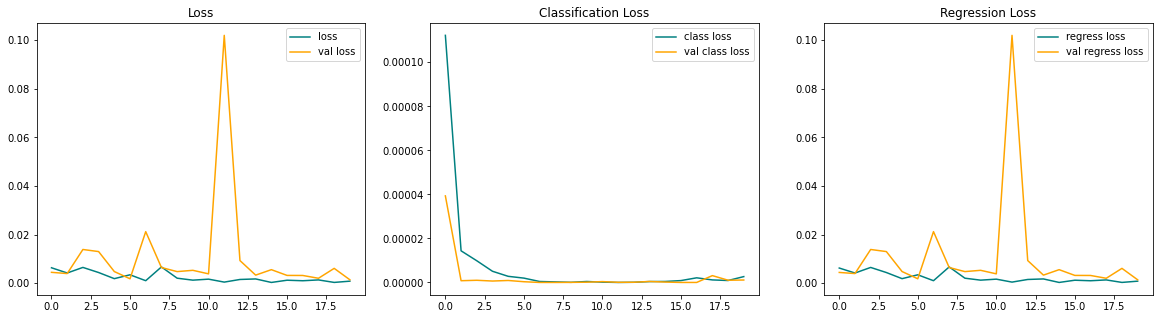

In [81]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

## Make Predictions

### Make Predictions on Test Set

In [82]:
test_data = test.as_numpy_iterator()

In [86]:
test_sample = test_data.next()

In [87]:
yhat = facetracker.predict(test_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


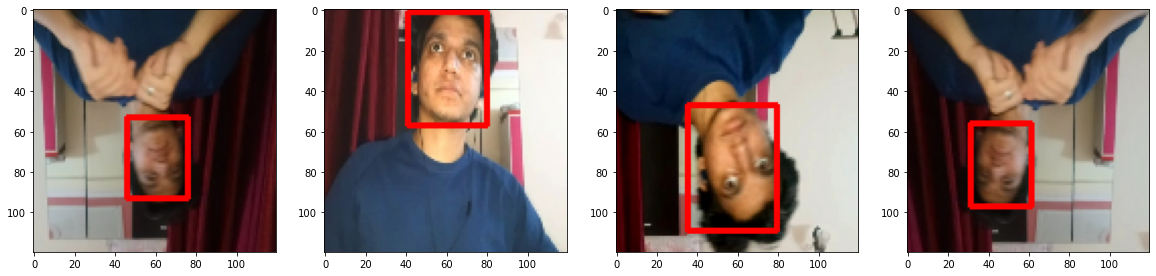

In [88]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### Save the Model

In [89]:
from tensorflow.keras.models import load_model

In [90]:
facetracker.save('facetracker_may17_20epoch.h5')

In [91]:
facetracker = load_model('facetracker_may17_20epoch.h5')

In [92]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [96]:
len(facetracker.get_weights())

34